In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensor,ToTensorV2
import glob
from sklearn.model_selection import train_test_split
import torchvision.models as models
import pandas as pd


import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone


from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

In [2]:
import time
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)


# Data preparation 

In [3]:
df=pd.read_csv("../input/global-wheat-detection/train.csv")
df.head()
df['image_id']=df['image_id']+'.jpg'
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7.jpg   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7.jpg   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7.jpg   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7.jpg   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7.jpg   1024    1024  usask_1   26.0  144.0  124.0  117.0

In [4]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name,img2):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['labels'][idx], category_id_to_name)
    plt.figure(figsize=(10, 10))
    plt.subplot(1,2,1)
    print(type(img))
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.show()

def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='coco', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['labels']))

# Example of Augmentation

<class 'numpy.ndarray'>


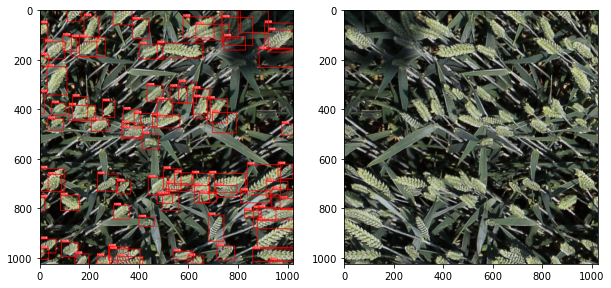

<class 'numpy.ndarray'>


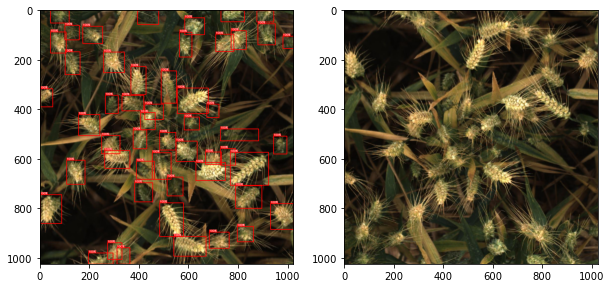

<class 'numpy.ndarray'>


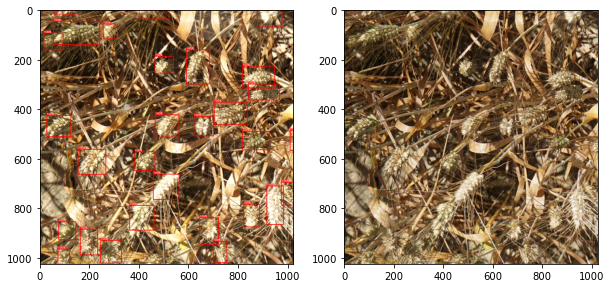

<class 'numpy.ndarray'>


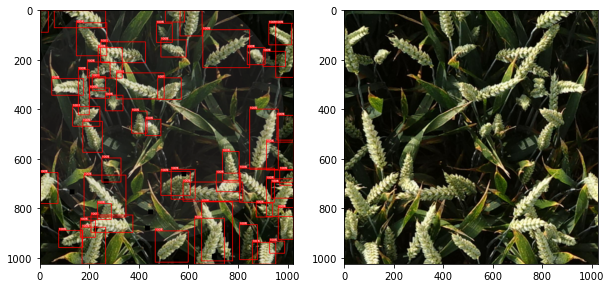

<class 'numpy.ndarray'>


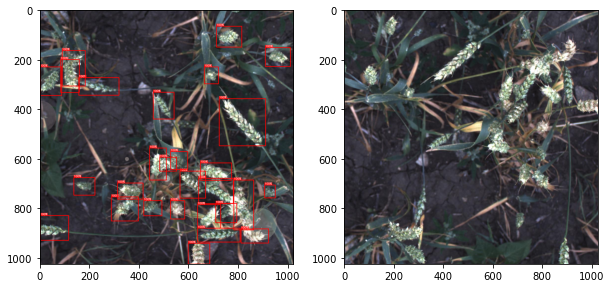

<class 'numpy.ndarray'>


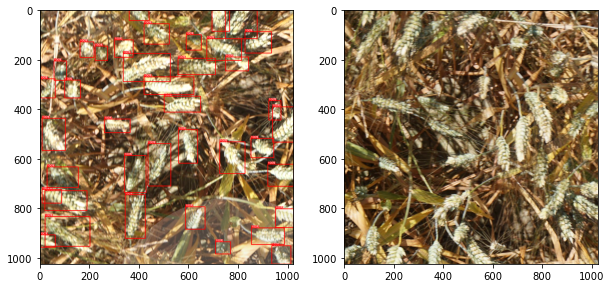

<class 'numpy.ndarray'>


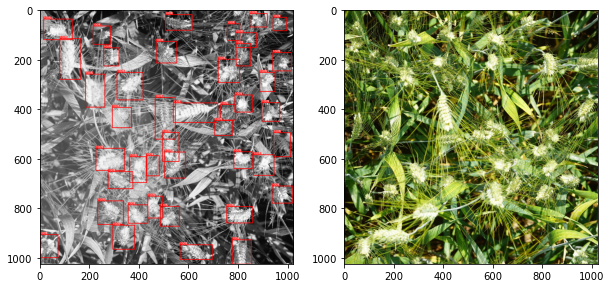

<class 'numpy.ndarray'>


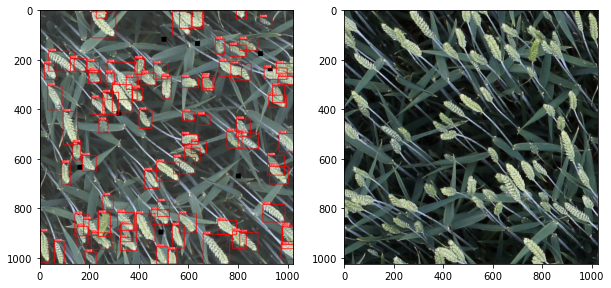

<class 'numpy.ndarray'>


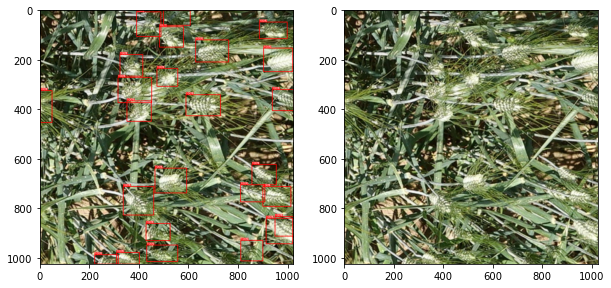

<class 'numpy.ndarray'>


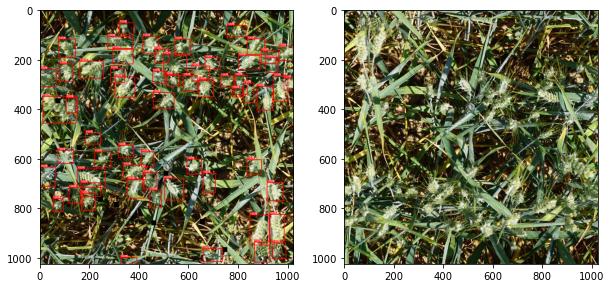

<class 'numpy.ndarray'>


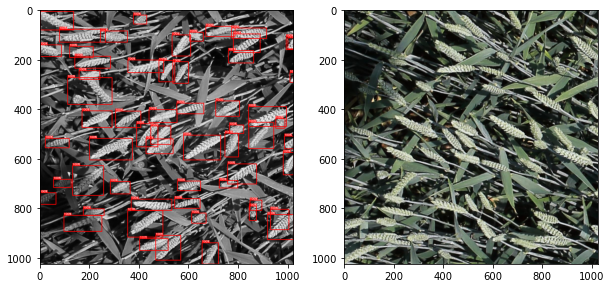

<class 'numpy.ndarray'>


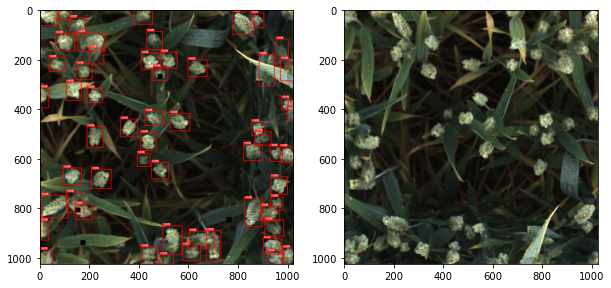

<class 'numpy.ndarray'>


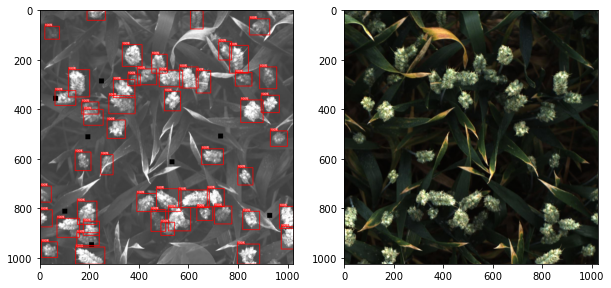

<class 'numpy.ndarray'>


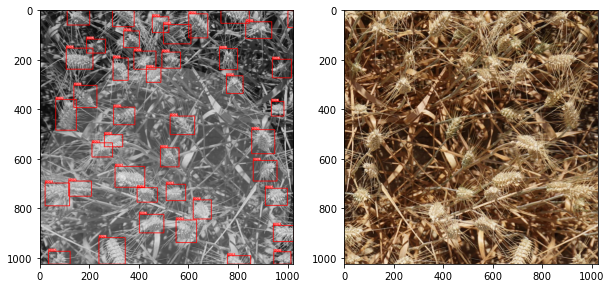

<class 'numpy.ndarray'>


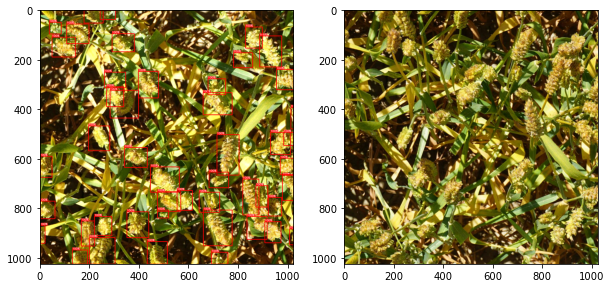

<class 'numpy.ndarray'>


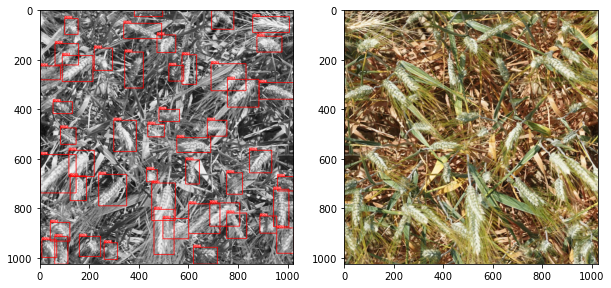

<class 'numpy.ndarray'>


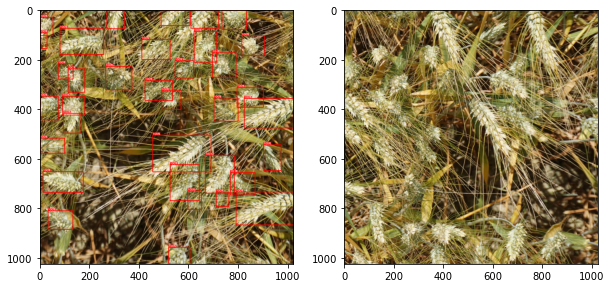

In [5]:
aug=[A.VerticalFlip(p=0.5),A.HorizontalFlip(p=0.5),A.RandomRotate90(p=0.5),A.Transpose(p=0.3),
     A.OneOf([
       A.RandomBrightness(p=0.5,limit=(0,0.3)),
       A.RandomBrightnessContrast(p=0.5,brightness_limit=(0,0.3), contrast_limit=0.15),
       A.RandomContrast(p=0.5,limit=0.15),
       A.HueSaturationValue(p=0.5,hue_shift_limit=0.2,sat_shift_limit=0.2,val_shift_limit=0.2)
        ],p=0.7),
     A.OneOf([A.Blur(p=0.05),A.RandomSunFlare(p=0.5,flare_roi=(0.3, 0.3, 0.5, 0.7),
                     num_flare_circles_lower=2, num_flare_circles_upper=4, src_radius=50),
             A.GaussianBlur(p=0.05)],p=0.4),
     A.Cutout(num_holes=8, max_h_size=20, max_w_size=20, fill_value=0, p=0.3),
     A.ToGray(p=0.2)]

transform=A.Compose(aug, bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

image_ids = df['image_id'].unique()
random.shuffle(image_ids)
valid_ids = image_ids[-500:]
train_ids = image_ids[:-500]

for i in range(0,len(valid_ids),30):
    image_id=valid_ids[i]
    img=cv2.imread('../input/global-wheat-detection/train/'+image_id)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #img=image1
    record=df[df['image_id'] == image_id]
    box=record[['x', 'y', 'w', 'h']].values
    img2=img.copy()

    sample={'image': img,'bboxes': box,'labels': [1]*len(box)}
    category_id_to_name = {0: '0',1:'100%'}
    annotation=transform(**sample)
    box=annotation['bboxes']

    visualize(annotation,category_id_to_name,img2)

In [6]:
#AverageMeter - class for averaging loss,metric
class AverageMeter(object):
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# DataLoader

In [7]:
class WheatDataset(Dataset):

    def __init__(self, path,df, transforms=None):
        self.path=path
        self.df=df
        self.transforms=transforms

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        p=self.path[idx]

        image1=cv2.imread('../input/global-wheat-detection/train/'+p,cv2.IMREAD_COLOR)
        image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB).astype(np.float32)
        image1 /= 255.0


        records = self.df[self.df['image_id'] == p]
        boxes = records[['x', 'y', 'w', 'h']].values
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target={}
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image1,
                'bboxes': boxes,
                'labels': labels
            }
            sample=self.transforms(**sample)
            image1 = sample['image']
            boxes  = sample['bboxes']
            labels = sample['labels']


        target['boxes']=torch.as_tensor(boxes, dtype=torch.float32)
        target["iscrowd"]=torch.as_tensor(iscrowd,dtype=torch.int64 )
        target['labels'] =  torch.as_tensor(labels,dtype=torch.int64 )
        target['area'] = area
        target["image_id"] = torch.tensor([idx])
        image1=torch.as_tensor(image1,dtype=torch.float32)
        return image1,target

In [8]:
category_id_to_name = {0: '0',1:'100%'}

image_ids = df['image_id'].unique()
random.shuffle(image_ids)
valid_ids = image_ids[-300:]
train_ids = image_ids[:-300]


aug=[A.VerticalFlip(p=0.5),A.HorizontalFlip(p=0.5),A.RandomRotate90(p=0.5),A.Transpose(p=0.3),
     A.OneOf([
       A.RandomBrightness(p=0.5,limit=(0,0.3)),
       A.RandomBrightnessContrast(p=0.5,brightness_limit=(0,0.3), contrast_limit=0.15),
       A.RandomContrast(p=0.5,limit=0.15),
       A.HueSaturationValue(p=0.5,hue_shift_limit=0.2,sat_shift_limit=0.2,val_shift_limit=0.2)
        ],p=0.7),
     A.OneOf([A.Blur(p=0.05),A.RandomSunFlare(p=0.5,flare_roi=(0.3, 0.3, 0.5, 0.7),
                     num_flare_circles_lower=2, num_flare_circles_upper=4, src_radius=50),
             A.GaussianBlur(p=0.05)],p=0.4),
     A.Cutout(num_holes=8, max_h_size=20, max_w_size=20, fill_value=0, p=0.3),
     A.ToGray(p=0.2),
     ToTensorV2(p=1.0)]


bbox=A.BboxParams(format='pascal_voc',label_fields=['labels'])
transform=A.Compose(aug, bbox_params=bbox,p=1)

transformValid=A.Compose([ ToTensorV2(p=1.0)], bbox_params=bbox,p=1)

def collate_fn(batch):
    return tuple(zip(*batch))

batch_s=10
dataset_train=WheatDataset(train_ids,df,transforms=transform)
train_loader=DataLoader(dataset_train,batch_size=batch_s,shuffle=True,collate_fn=collate_fn)

dataset_val=WheatDataset(valid_ids,df,transforms=transformValid)
val_loader=DataLoader(dataset_val,batch_size=4,collate_fn=collate_fn,shuffle=True)


In [9]:
len(train_ids),len(valid_ids)

(3073, 300)

# Train and Val

In [10]:
from tqdm import tqdm, notebook


def train(epoch_number,model,optim,train_losses):
    model.train()
    train_losses.reset()
    tqdm_loader=tqdm(train_loader)
    for  index,(img,target) in enumerate(tqdm_loader):
        img = list(image.to(device) for image in img)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]

        out=model(img,target)
        loss1 = sum(loss1 for loss1 in out.values())

        # track the loss
        optim.zero_grad()
        loss1.backward()
        optim.step()

        train_losses.update(loss1.item(),n=batch_s)

        tqdm_loader.set_description("Epoch {} loss item ={:4} avg={:4} ".format(epoch_number,round(loss1.item(),4),round(train_losses.avg,4)))

In [11]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [12]:

def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:

    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

In [13]:

def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:

    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [14]:
def val(epoch_number,model):
    tqdm_loader=tqdm(val_loader)
    model.eval()
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    validation_image_precisions = []
    
    with torch.no_grad():
    
        for step, (images, targets) in enumerate(tqdm_loader):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i, image in enumerate(images):
                boxes = outputs[i]['boxes'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                preds_sorted_idx = np.argsort(scores)[::-1]
                preds_sorted = boxes[preds_sorted_idx]
                image_precision = calculate_image_precision(preds_sorted, gt_boxes, thresholds=iou_thresholds,form='pascal_voc')
                validation_image_precisions.append(image_precision)
            tqdm_loader.set_description("Val Epoch {}  precision={:4} ".format(epoch_number,round(np.mean(validation_image_precisions),4)))

    
  
    

In [15]:
def fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2, pretrained_backbone=False, **kwargs):
    backbone = resnet_fpn_backbone('resnet50', pretrained_backbone)
    model = FasterRCNN(backbone, num_classes, **kwargs)
    return model

In [16]:
def get_model_101():
    backbone = resnet_fpn_backbone('resnet101', pretrained=False)
    model = FasterRCNN(backbone, num_classes=2)
    return model

In [17]:
#model1 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model1=get_model_101()
# get number of input features for the classifier
#in_features = model1.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
#model1.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model1.load_state_dict(torch.load("../input/faster-cnn-final-model/fastercnn_resnet_101_145.pth"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1=model1.to(device)
sgd=torch.optim.SGD(model1.parameters(),lr=0.0007,momentum=0.9, weight_decay=0.0005)
train_losses = AverageMeter()  

# Model Start to train

In [18]:
for i in range(1):
    train(i,model1,sgd,train_losses)
    val(i,model1)

  0%|          | 0/308 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
Val Epoch 0  precision=0.8008 : 100%|██████████| 75/75 [01:00<00:00,  1.24it/s]


# Example of val and save weight of model

In [19]:
#val example
index_img=0
images, targets = next(iter(val_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[index_img]['boxes'].cpu().numpy().astype(np.float32)
sample2 = images[index_img].permute(1,2,0).cpu().numpy()
#pred val
model1.eval()
cpu_device = torch.device("cpu")
outputs = model1(images)
outputs=outputs[index_img]
outputs = [{k: v.to(cpu_device) for k, v in outputs.items()} ]

In [20]:
#get box&score to plot 
box1=outputs[0]['boxes'].cpu().detach().numpy()
scores=outputs[0]['scores'].cpu().detach().numpy()
image1=images[index_img].cpu().numpy()
print(len(boxes)," ",len(box1),"  ",scores)
print("boxes : ", sum(scores >0.5))

79   77    [0.9997936  0.9995987  0.99959093 0.9995209  0.9992489  0.9991454
 0.99907506 0.9990677  0.999003   0.9989328  0.9989046  0.99867177
 0.99865216 0.9985978  0.9985507  0.99840516 0.99826485 0.9980379
 0.99795973 0.9978908  0.99778336 0.9976636  0.99743253 0.99736893
 0.99721575 0.99695086 0.9967654  0.99666494 0.99619544 0.9960984
 0.99595827 0.995684   0.99547017 0.995372   0.9952755  0.995004
 0.99438125 0.99410963 0.99350595 0.99306375 0.9927079  0.9926604
 0.99184763 0.9912947  0.98974484 0.98931944 0.9892107  0.9892063
 0.98915124 0.98795927 0.9876797  0.9874165  0.9873958  0.9870891
 0.98707205 0.98490095 0.984863   0.9834055  0.9803862  0.9712559
 0.9707183  0.9686762  0.96867037 0.9637113  0.9621543  0.9585425
 0.95602053 0.94584984 0.94221956 0.927813   0.87850547 0.86103594
 0.83095187 0.8186821  0.5543721  0.09491105 0.0572327 ]
boxes :  75


<class 'numpy.ndarray'>


<Figure size 864x864 with 0 Axes>

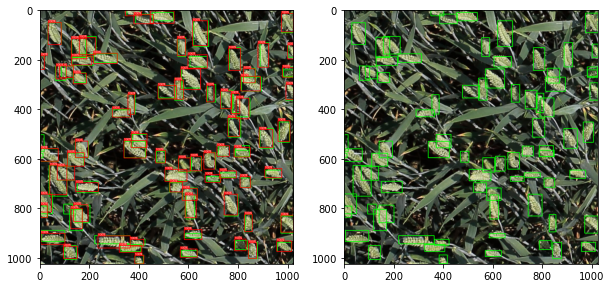

In [21]:
for i in range(len(boxes)):
    cv2.rectangle(sample2,(int(boxes[i][0]),int(boxes[i][1])),(int(boxes[i][2]),int(boxes[i][3])),
                (0,255,0),2)

def get_box(box11):
    box_sample=[int(box11[0]),int(box11[1]),int(box11[2]),int(box11[3])]
    box_sample[2]=box_sample[2]-box_sample[0]
    box_sample[3]=box_sample[3]-box_sample[1]
    return box_sample



aug=[]
transform=A.Compose(aug, bbox_params=A.BboxParams(format='coco', min_area=0, 
                                               min_visibility=0, label_fields=['labels']),p=1)
list_box=[]
for i in range(len(box1)):
    if scores[i] >0.5:
        list_box.append(get_box(box1[i]))

sample={'image': sample2,'bboxes': list_box,'labels': [1]*len(list_box)}
category_id_to_name = {0: '0',1:'100%'}
annotation=transform(**sample)
plt.figure(figsize=[15,15])
visualize(annotation,category_id_to_name,sample2)

In [22]:
torch.save(model1.state_dict(), 'fastercnn_resnet_101.pth')